In [105]:
# find relevant regions
# pseudocode



# Get 

In [106]:

import argparse

from svinterface.manager import Manager
from svinterface.core.polydata import Centerlines
import numpy as np
from tqdm import tqdm

def dist(p1, p2):
    # euclidian distance
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2 )
    
def find_closest(p1, stented_gids, stented_points):
    """Finds GID of closest point"""
    min_gid = stented_gids[0]
    min_dist = dist(p1, stented_points[min_gid])
    
    for gid, p2 in list(zip(stented_gids, stented_points)):
        tmp_dist = dist(p1, p2)
        # check if smaller. update gid
        if tmp_dist < min_dist:
            min_dist = tmp_dist
            min_gid = gid
    
    return min_gid, min_dist
            

In [176]:
def match_centerlines(diseased_cent: Centerlines, stented_cent: Centerlines):
    # check for valid
    caps = diseased_cent.get_pointdata_array("Caps_0D")
    junc = diseased_cent.get_pointdata_array("Junctions_0D")
    vess = diseased_cent.get_pointdata_array("Vessels_0D")
    valid = caps + junc + vess + 3
    
    # get valid gid
    gids = diseased_cent.get_pointdata_array("GlobalNodeId")
    valid_gids = gids[valid > 0]
    poi_points = diseased_cent.get_points()[valid_gids]
    
    # for every point on the stented cent, find closest point
    stented_points = stented_cent.get_points()
    stented_gids = stented_cent.get_pointdata_array("GlobalNodeId")
    
    gids_map = {} # old_gid: new_gid
    distances = []
    for idx, p1 in enumerate(poi_points):
        
        gid, dist = find_closest(p1, stented_gids, stented_points)
        distances.append((valid_gids[idx],gid,dist))
        
    return distances

In [190]:
dis_cent = Centerlines.load_centerlines("../../data/diseased/AS1_SU0308_stent/results/AS1_SU0308_nonlinear/AS1_SU0308_centerlines.vtp")
stent_cent = Centerlines.load_centerlines("../../data/diseased/AS1_SU0308_stent/results/AS1_SU0308_nonlinear/3D_DIR/RPA_2_stent/AS1_SU0308_3D_RPA_stented_2_centerlines.vtp")

In [191]:
d = match_centerlines(dis_cent,stent_cent)

In [192]:
print(sorted(d, key=lambda x: x[2], reverse=True))

[(12451, 11531, 0.5364923289397772), (16274, 15014, 0.3209043901170083), (16849, 15492, 0.11963522513321587), (16884, 15524, 0.11920929662114362), (13700, 12635, 0.11121634343427678), (12516, 12362, 0.09580617100058451), (1, 1, 0.04428457987829443), (13714, 13785, 0.038920941035928226), (24761, 22963, 0.02659597294883554), (854, 852, 0.017463031341685097), (517, 541, 0.016896011465458653), (988, 981, 0.011924029900636537), (1238, 1283, 0.011808647723175197), (21031, 19297, 0.010971241692729759), (1614, 1663, 0.010477166121217695), (16329, 15040, 0.010204082961537261), (20895, 19170, 0.009639058605286695), (3176, 3144, 0.009440156781645764), (17184, 15783, 0.008848576252398526), (21919, 20213, 0.008175502472029356), (3174, 3027, 0.008162379250032884), (1979, 2015, 0.008074220900860138), (23771, 21996, 0.008060636496629045), (7439, 7012, 0.008008152028593932), (14488, 13371, 0.00746923453029847), (19105, 17556, 0.007392045183095811), (17505, 16065, 0.007190246855866803), (19362, 17827, 0

In [193]:
d.sort(key=lambda x: x[2], reverse=True)

In [194]:
import matplotlib.pyplot as plt

In [195]:
distances = np.array(d)[:,2]

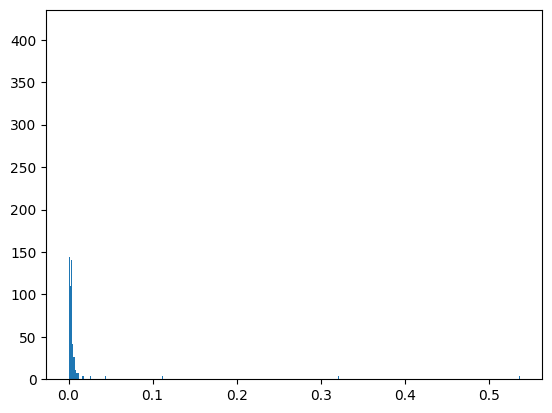

In [196]:
_ = plt.hist(np.array(d)[:,2], bins='auto', density=True)

In [197]:
d[:np.where(distances > distances.mean() + 2*distances.std())[0][-1] + 1]

[(12451, 11531, 0.5364923289397772),
 (16274, 15014, 0.3209043901170083),
 (16849, 15492, 0.11963522513321587),
 (16884, 15524, 0.11920929662114362),
 (13700, 12635, 0.11121634343427678),
 (12516, 12362, 0.09580617100058451)]

In [198]:
from svinterface.core.zerod.lpn import LPN

In [199]:
lpn = LPN.from_file('../../data/diseased/AS1_SU0308_stent/results/AS1_SU0308_nonlinear/parameterization/AS1_SU0308.in')

In [200]:
topk = 4
t = set(np.array(d[:np.where(distances > distances.mean() + 2*distances.std())[0][-1] + 1])[:,0].astype(int))
valid_junc_ids = set()
valid_vess_ids = set()
for node in lpn.tree_bfs_iterator(lpn.get_tree()):
    for idx, vinfo in enumerate(node.vessel_info):
        if node.type == 'junction':
            if vinfo['gid'][0] in t or set(vinfo['gid'][1]).intersection(t):
                print(vinfo['gid'], node.ids[idx])
                valid_junc_ids.add(node.ids[idx])
        elif node.type == 'branch':
            if set(vinfo['gid']).intersection(t):
                print(vinfo['gid'], node.ids[idx])
                valid_vess_ids.add(node.ids[idx])

[12388, [12451, 13700, 16274, 16849]] J22
[12451, 12516] 82
[13700, 13714] 90
[16274, 16329] 106
[16849, 16884] 109
[12516, [12575, 13346]] J23
[16884, [16992, 18296, 18828, 19362, 20895, 21781, 21919, 22431, 22713, 23139, 23757]] J33


In [201]:
valid_junc_ids, valid_vess_ids

({'J22', 'J23', 'J33'}, {82, 90, 106, 109})